Se van a analizar solo datos sintéticos ya que los datos de MoCap no están bien sincronizados con la imágen 


## Imports

In [2]:
import cv2
import mediapipe as mp
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import keras
import pickle
import time
import tensorflow as tf
from scipy.spatial import distance
from matplotlib import pyplot as plt
import random
import shutil
import traceback

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

## Variables

In [4]:
mapping_numbers_variables = {0:'right_shoulder',
                             1:'right_elbow',
                             2:'right_wrist',
                             3:'left_shoulder',
                             4:'left_elbow',
                             5:'left_wrist'}

columns_df_2D_interest = ['right_shoulder_2D','right_shoulder_2D.1',
                          'right_elbow_2D','right_elbow_2D.1',
                          'right_wrist_2D', 'right_wrist_2D.1',          
                          'left_shoulder_2D','left_shoulder_2D.1',  
                          'left_elbow_2D','left_elbow_2D.1',
                          'left_wrist_2D','left_wrist_2D.1']

columns_df_3D_interest = ['right_shoulder','right_shoulder.1','right_shoulder.2',
                          'right_elbow', 'right_elbow.1','right_elbow.2',
                          'right_wrist','right_wrist.1','right_wrist.2',
                          'left_shoulder','left_shoulder.1','left_shoulder.2',
                          'left_elbow', 'left_elbow.1', 'left_elbow.2',
                          'left_wrist','left_wrist.1','left_wrist.2']


#Initialize the Mediapipe module with its corresponding parameters
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(model_complexity=1,min_detection_confidence=0.5,min_tracking_confidence=0.5)

In [5]:
model = keras.models.load_model('../models/Experiment_B_NO/model.h5')
scaler = pickle.load(open('../models/Experiment_B_NO/scaler.pkl','rb'))

#Select the number of keypoints to detect 
number_keypoints_to_detect = 6

#Select the indices of the landmarks of interest to detect from the output of the previous cell
indices_landmark_interest = [11, 12, 13, 14, 15 ,16] #0rder: left shoulder, right shoulder, left elbow, right elbow, left wrist, right wrist

C:\Users\Eodyne-TestStation\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


### Functions

In [6]:
def mediapipe_inference(frame):
    results = pose.process(frame)
    frame_list1 = []
    point_coords_landmark_interest = []
    start_index = 0
    if results.pose_landmarks:
        for landmark in results.pose_landmarks.landmark:
            if start_index in indices_landmark_interest:
                image_hight, image_width, _ = frame.shape
                frame = cv2.circle(frame, (int(landmark.x*image_width), int(landmark.y*image_hight)), radius=5, color = (0,255,0), thickness=-1)   
                frame_list1.append(landmark.x*image_width)
                frame_list1.append(landmark.y*image_hight) 
                start_index = start_index+1
            else:
                start_index = start_index+1
            
    return(frame_list1,frame)

In [7]:
def split_3_coordinates(values_array): 
    output = []
    for i in range(0, len(values_array)):
        m = 0
        r = 3
        frame_coordinates = []
        for j in range(0,int(len(values_array[i])/3)):
            frame_coordinates.append(values_array[i][m:r])
            m = r
            r = r+3
        output.append(frame_coordinates)
    return(output)

def split_2_coordinates(values_array): 
    output = []
    for i in range(0, len(values_array)):
        m = 0
        r = 2
        frame_coordinates = []
        for j in range(0,int(len(values_array[i])/2)):
            frame_coordinates.append(values_array[i][m:r])
            m = r
            r = r+2
        output.append(frame_coordinates)
    return(output)

def split_2_coordinates_array(values_array): 
    m = 0
    r = 2
    frame_coordinates = []
    for j in range(0,int(len(values_array)/2)):
        frame_coordinates.append(values_array[m:r])
        m = r
        r = r+2 
    return(frame_coordinates)

### Load ground truth synthetic test data

In [8]:
#Filtered_csv are files that just consider the recorded time of RGS movements in the MOCAP studio
df = pd.read_csv('../dataset/csv_files/Exported_Synth_Dataset_Unity.csv') #Exported synthethic dataset
df_gt_2D = df[columns_df_2D_interest].reset_index().drop(columns=['index'])[0:149997] #Just these rows because other contain Nans (Don't Know Why)
df_gt_3D = df[columns_df_3D_interest].reset_index().drop(columns=['index'])[0:149997] #Just these rows because other contain Nans (DKW)
print(df_gt_2D.shape)
print(df_gt_3D.shape)

(149997, 12)
(149997, 18)


In [9]:
# Transform synthetic "Y" to the mediapipe coordinate system as it is different and for comparison purposes should be in the same format
height,width = (1080,1920)

#Selecting columns containint Y coordinates
y_cols_gt = []

for value in df_gt_2D:
    if len(value.split('.')) == 2:
        y_cols_gt.append(value)

#Aplico conversion a sistema opencv//Mediapipe
df_gt_y = df_gt_2D[y_cols_gt]
df_gt_y = height - df_gt_y  

#Replace de las y en df_gt
df_gt_2D[y_cols_gt] = df_gt_y

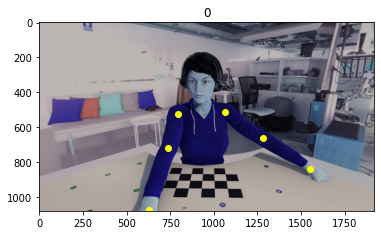

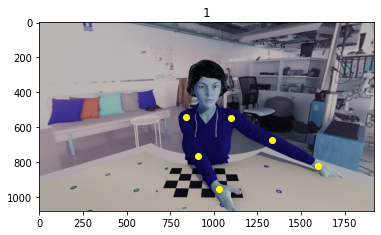

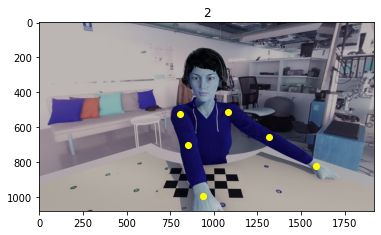

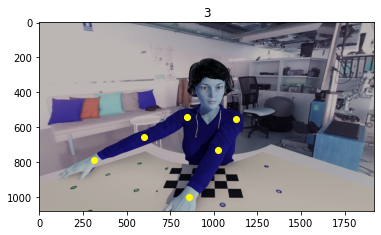

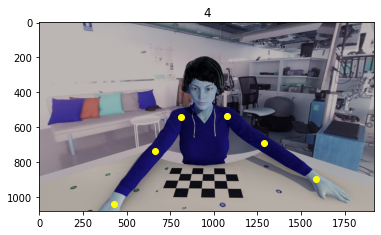

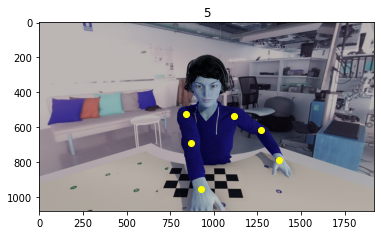

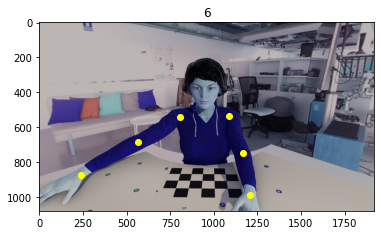

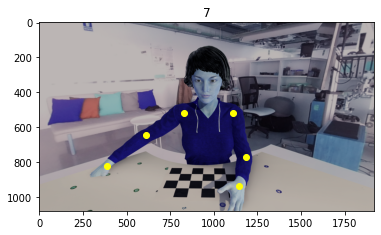

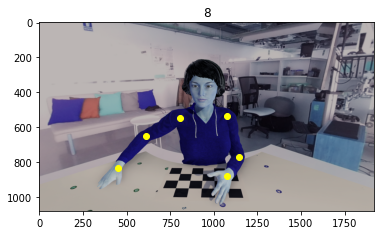

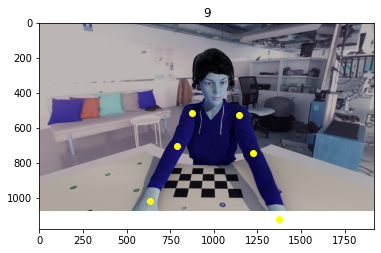

In [9]:
#To check if gt 2D coordinates are ok
images = glob('../dataset/00Images/*.png')[0:10]
n = 0
for image in images:
    plt.imshow(cv2.imread(image))
    plt.scatter(np.array(split_2_coordinates_array(np.array(df_gt_2D.iloc[n])))[:,0], np.array(split_2_coordinates_array(np.array(df_gt_2D.iloc[n])))[:,1], color = 'yellow')
    plt.title(n)
    plt.show()
    n = n+1

### Inference MediaPipe

### Load predicted data

Loading the data causes that cell elements are strings, hence this has to be changed

In [10]:
df_pred_2D = pd.read_csv('../dataset/csv_files/Entire_149998_Synth_Predicted_2D.csv').reset_index().drop(columns=['index'])[0:149997]
print(df_pred_2D.shape)

(149997, 12)


### Postprocessing data

In [11]:
df_pred_2D = df_pred_2D.reset_index().drop(columns=['index'])
print(df_pred_2D.shape)

(149997, 12)


In [12]:
#ROWS WHERE KEYPOINTS HAVE NOT BEEN DETECTED DUE TO MEDIAPIPE ISSUES
#Get the index of the rows that contain a NaN
nans_index_rows = list(df_pred_2D[df_pred_2D.isna().any(axis=1)].index)
len(nans_index_rows)

0

In [13]:
#Get the index of the rows that contain full 0.00
zeros_index_rows = list(df_pred_2D[(df_pred_2D['2'] == 0.0)&(df_pred_2D['3'] == 0.0)&(df_pred_2D['6'] == 0.0)&(df_pred_2D['7'] == 0.0)&(df_pred_2D['10'] == 0.0)&(df_pred_2D['11'] == 0.0)&(df_pred_2D['0'] == 0.0)&(df_pred_2D['0'] == 0.0)&(df_pred_2D['1'] == 0.0)&(df_pred_2D['4'] == 0.0)&(df_pred_2D['5'] == 0.0)&(df_pred_2D['8'] == 0.0)&(df_pred_2D['9'] == 0.0)].index)
#zeros_index_rows = list(df_pred_2D[(df_pred_2D[2] == 0.0)&(df_pred_2D[3] == 0.0)&(df_pred_2D[6] == 0.0)&(df_pred_2D[7] == 0.0)&(df_pred_2D[10] == 0.0)&(df_pred_2D[11] == 0.0)&(df_pred_2D[0] == 0.0)&(df_pred_2D[0] == 0.0)&(df_pred_2D[1] == 0.0)&(df_pred_2D[4] == 0.0)&(df_pred_2D[5] == 0.0)&(df_pred_2D[8] == 0.0)&(df_pred_2D[9] == 0.0)].index)
len(zeros_index_rows)

702

In [14]:
#Drop the rows that contain nans and zeros of predicted and ground-truth 2D
df_pred_2D = df_pred_2D.drop(nans_index_rows)
df_gt_2D = df_gt_2D.drop(nans_index_rows)

df_pred_2D = df_pred_2D.drop(zeros_index_rows)
df_gt_2D = df_gt_2D.drop(zeros_index_rows)

In [15]:
print(df_gt_2D.shape)
print(df_pred_2D.shape)

(149295, 12)
(149295, 12)


In [16]:
df_pred_2D.to_csv('../dataset/csv_files/2D_MP_Prediction_No_Nans_No_Zeros.csv', header=None, index=None)
df_gt_2D.to_csv('../dataset/csv_files/2D_GT_Prediction_No_Nans_No_Zeros.csv', header=None, index=None)

In [17]:
#Drop the rows that contain nans and zeros of ground-truth 3D
df_gt_3D_4_MP = df_gt_3D.drop(nans_index_rows)
df_gt_3D_4_MP = df_gt_3D_4_MP.drop(zeros_index_rows)

In [32]:
df_gt_3D_4_MP.reset_index().drop(columns=['index']).to_csv('../dataset/csv_files/3D_GT_NoNans_No_Zeros.csv',header=None, index=None)

In [34]:
#Splitting 2D df
df_pred_2D_splitted = pd.DataFrame(split_2_coordinates(np.array(df_pred_2D).astype(float)))
df_gt_2D_splitted = pd.DataFrame(split_2_coordinates(np.array(df_gt_2D).astype(float)))

In [35]:
df_pred_2D_splitted.head(5)

,0,1,2,3,4,5
0,"[793.7100219726562, 520.6142592430115]","[719.7092056274414, 769.3823647499084]","[620.5971908569336, 1016.7719221115112]","[1084.7597122192385, 514.9440908432007]","[1280.0001525878904, 663.9928579330443]","[1516.19384765625, 811.3162350654602]"
1,"[825.5942344665527, 532.9155886173248]","[879.1632270812987, 765.6991982460022]","[1010.5388259887696, 959.061062335968]","[1105.2675247192385, 528.7866711616516]","[1317.809600830078, 673.2038640975952]","[1567.291374206543, 811.7293167114258]"
2,"[819.3967437744141, 530.268988609314]","[875.1945304870605, 760.5938386917114]","[936.9635009765624, 974.5078825950624]","[1103.5572052001953, 518.9642179012299]","[1309.4476318359375, 670.3191161155702]","[1563.4697341918945, 811.5056848526001]"
3,"[823.4750175476074, 526.2055063247682]","[634.8453140258789, 690.2061295509337]","[350.38344383239746, 807.6769065856934]","[1116.2343978881836, 544.3960332870483]","[1009.277229309082, 795.8223581314087]","[843.8705635070801, 993.6846041679382]"
4,"[813.486499786377, 538.6121821403503]","[633.9815139770508, 749.3274664878845]","[436.07791900634766, 950.05553483963]","[1112.8789901733396, 539.7105145454407]","[1238.1722259521484, 747.9563212394714]","[1494.3194961547852, 917.7400875091553]"


## Compute PCK@0.5

In [36]:
#Compute the euclidean distance for each keypoint between the ground truth and the prediction
all_distances = []
#For each keypoint
for i in range(0,df_pred_2D_splitted.shape[1]):
    keypoint_distances = []
    for j in range(0,len(df_gt_2D_splitted[i])):
        try:
            keypoint_distances.append(distance.euclidean(df_gt_2D_splitted[i][j], df_pred_2D_splitted[i][j]))
        
        except Exception as e: 
            print(j)
            print(e)
            pass
    all_distances.append(keypoint_distances)

df_ED = pd.DataFrame(all_distances).T
df_ED = df_ED.rename(columns=mapping_numbers_variables)

In [37]:
df_ED.mean()

right_shoulder    18.042244
right_elbow       41.843229
right_wrist       52.861567
left_shoulder     18.700196
left_elbow        41.650235
left_wrist        55.123410
dtype: float64

In [38]:
df_ED.std()

right_shoulder     8.702237
right_elbow       21.463670
right_wrist       37.733741
left_shoulder      9.215709
left_elbow        23.304221
left_wrist        40.805855
dtype: float64

([<matplotlib.axis.XTick at 0x2de0e37af70>,
 [Text(1, 0, 'right_shoulder'),
  Text(2, 0, 'right_elbow'),
  Text(3, 0, 'right_wrist'),
  Text(4, 0, 'left_shoulder'),
  Text(5, 0, 'left_elbow'),
  Text(6, 0, 'left_wrist')])

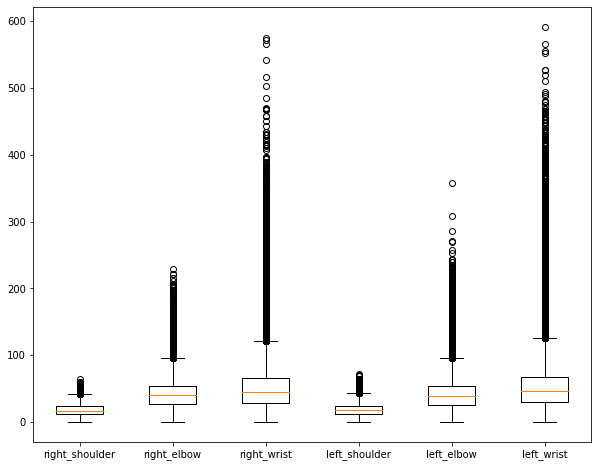

In [39]:
plt.figure(figsize=(10,8))
plt.boxplot(pd.DataFrame(all_distances).T)
positions = list(mapping_numbers_variables.keys())
positions = [i+1 for i in positions]
labels = list(mapping_numbers_variables.values())
plt.xticks(positions,labels)

In [40]:
#150 pixels is the head bone link of the woman virtual character. (Head-bone link --> Des de el entrecejo hasta inicio columna)
threshold = 0.5*150 

#Se calcula PCK por cada imágen y luego se hace la media

PCK_per_image = []
#For each image
for i in range(0,len(df_ED)):
    condition = []
    #For each euclidean distance computed, if the ED is below a certain treshold, consider it good(1.0), if not, consider it bad (0.0)
    for di in df_ED.iloc[i]:
        condition.append(di < threshold)
    PCK_per_image.append(sum(condition)/number_keypoints_to_detect)
        
        
PCK = sum(PCK_per_image)/len(PCK_per_image)
print('The PCK@0.5 for the MediaPipe Detections is: '+str(PCK))

The PCK@0.5 for the MediaPipe Detections is: 0.9131607443871791


### Creating 3 different dfs based on euclidean distances
- If an image has all keypoints <= 75px --> Low_PCK
- If an image has all keypoints 75px < keypoints <125px --> Medium_PCK
- If an image has all keypoints >= 125px --> High  PCK

In [54]:
#images = glob('C:\\Synthetic_dataset\\*.png')

low_indexes = []
medium_indexes = []
high_indexes = []

#Per a cadascuna de les imatges que no tenen Nans ni Zeros
for i in range(0,len(df_ED)):
    #Index of the dataframe
    if sum(df_ED[['right_shoulder','right_elbow','right_wrist','left_shoulder','left_elbow','left_wrist']].iloc[i] <= 75) == number_keypoints_to_detect: 
        #shutil.move(images[index], 'C:\\Users\\Eodyne-TestStation\\Desktop\\RBT_TestingAnalysis\\dataset\\synth\\images\\Low_PCK\\'+images[index].split('\\')[-1])
        low_indexes.append(i)      
    
    elif sum(df_ED[['right_shoulder','right_elbow','right_wrist','left_shoulder','left_elbow','left_wrist']].iloc[i] < 125) == 6:
        #shutil.move(images[index], 'C:\\Users\\Eodyne-TestStation\\Desktop\\RBT_TestingAnalysis\\dataset\\synth\\images\\Medium_PCK\\'+images[index].split('\\')[-1])
        medium_indexes.append(i)  
    else:
        #shutil.move(images[index], 'C:\\Users\\Eodyne-TestStation\\Desktop\\RBT_TestingAnalysis\\dataset\\synth\\images\\High_PCK\\'+images[index].split('\\')[-1])
        high_indexes.append(i)
            

In [65]:
low_df_pred_2D = df_pred_2D.reset_index().drop(columns=['index']).iloc[low_indexes]
low_df_gt_3D = df_gt_3D_4_MP.reset_index().drop(columns=['index']).iloc[low_indexes]


medium_df_pred_2D = df_pred_2D.reset_index().drop(columns=['index']).iloc[medium_indexes]
medium_df_gt_3D = df_gt_3D_4_MP.reset_index().drop(columns=['index']).iloc[medium_indexes]


high_df_pred_2D = df_pred_2D.reset_index().drop(columns=['index']).iloc[high_indexes]
high_df_gt_3D = df_gt_3D_4_MP.reset_index().drop(columns=['index']).iloc[high_indexes]

In [68]:
print(low_df_pred_2D.shape)
print(medium_df_pred_2D.shape)
print(high_df_pred_2D.shape)

(88695, 12)
(45959, 12)
(14641, 12)


In [73]:
low_df_pred_2D.to_csv('../dataset/csv_files/splitted/low_2D_MP.csv',index=None)
low_df_gt_3D.to_csv('../dataset/csv_files/splitted/low_3D_GT.csv',index=None)

medium_df_pred_2D.to_csv('../dataset/csv_files/splitted/medium_2D_MP.csv',index=None)
medium_df_gt_3D.to_csv('../dataset/csv_files/splitted/medium_3D_GT.csv',index=None)

high_df_pred_2D.to_csv('../dataset/csv_files/splitted/high_2D_MP.csv',index=None)
high_df_gt_3D.to_csv('../dataset/csv_files/splitted/high_3D_GT.csv',index=None)